In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/Face_Mask_detection')

Mounted at /content/Face_Mask_detection


In [ ]:
!ls "/content/Face_Mask_detection/MyDrive/Face_Mask_detection"

with_mask  without_mask


In [ ]:
dataset=r'/content/Face_Mask_detection/MyDrive/Face_Mask_detection'
imagePaths=list(paths.list_images(dataset))

In [ ]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

In [ ]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [ ]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [ ]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [ ]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [ ]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
print(baseModel.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [68]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [69]:
for layer in baseModel.layers:
    layer.trainable=False




In [70]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [71]:
learning_rate=0.001
Epochs=20
BS=32

In [72]:
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [73]:
H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)

Epoch 1/20
34/34 [==============================] - 16s 391ms/step - loss: 0.2215 - accuracy: 0.9322 - val_loss: 0.0322 - val_accuracy: 0.9892
Epoch 2/20
34/34 [==============================] - 12s 339ms/step - loss: 0.0820 - accuracy: 0.9712 - val_loss: 0.0248 - val_accuracy: 0.9892
Epoch 3/20
34/34 [==============================] - 12s 345ms/step - loss: 0.0671 - accuracy: 0.9777 - val_loss: 0.0199 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 12s 338ms/step - loss: 0.0389 - accuracy: 0.9926 - val_loss: 0.0173 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 12s 340ms/step - loss: 0.0389 - accuracy: 0.9851 - val_loss: 0.0170 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 14s 406ms/step - loss: 0.0341 - accuracy: 0.9907 - val_loss: 0.0127 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 12s 344ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0165 - val_accuracy: 0.9928

In [74]:
model_name = '/content/mask_detection_best.h5'
model.save(model_name)

In [ ]:
!ls

Face_Mask_detection  mask_detection_best.h5  sample_data


In [75]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       139

    accuracy                           0.99       277
   macro avg       0.99      0.99      0.99       277
weighted avg       0.99      0.99      0.99       277



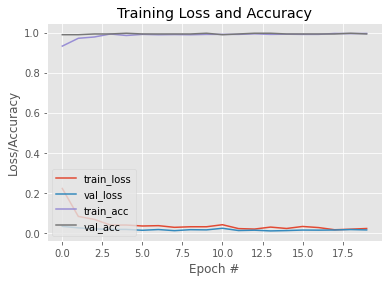

In [76]:
# plot the training loss and accuracy

N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

In [ ]:
prototxtPath=('deploy.prototxt')
weightsPath=('res10_300x300_ssd_iter_140000.caffemodel')

In [ ]:
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [77]:
model=load_model('mask_detection_best.h5')

In [78]:
image=cv2.imread('example_02.png')


In [79]:
from google.colab.patches import cv2_imshow

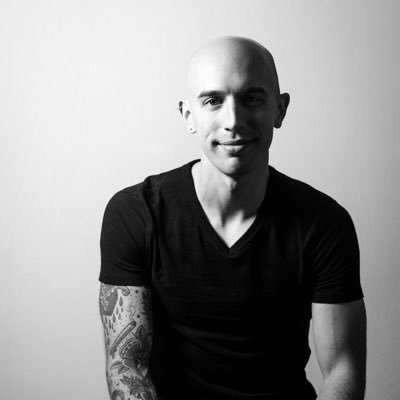

In [80]:
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [81]:
(h,w)=image.shape[:2]

In [82]:
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

In [83]:
blob

array([[[[131., 131., 131., ...,  66.,  65.,  65.],
         [131., 131., 131., ...,  66.,  65.,  65.],
         [131., 131., 131., ...,  66.,  65.,  65.],
         ...,
         [ 65.,  65.,  67., ...,  16.,  14.,  14.],
         [ 65.,  66.,  67., ...,  14.,  13.,  11.],
         [ 65.,  66.,  67., ...,  13.,  10.,   8.]],

        [[ 58.,  58.,  58., ...,  -7.,  -8.,  -8.],
         [ 58.,  58.,  58., ...,  -7.,  -8.,  -8.],
         [ 58.,  58.,  58., ...,  -7.,  -8.,  -8.],
         ...,
         [ -8.,  -8.,  -6., ..., -57., -59., -59.],
         [ -8.,  -7.,  -6., ..., -59., -60., -62.],
         [ -8.,  -7.,  -6., ..., -60., -63., -65.]],

        [[112., 112., 112., ...,  47.,  46.,  46.],
         [112., 112., 112., ...,  47.,  46.,  46.],
         [112., 112., 112., ...,  47.,  46.,  46.],
         ...,
         [ 46.,  46.,  48., ...,  -3.,  -5.,  -5.],
         [ 46.,  47.,  48., ...,  -5.,  -6.,  -8.],
         [ 46.,  47.,  48., ...,  -6.,  -9., -11.]]]], dtype=float32)

In [84]:
blob.shape

(1, 3, 300, 300)

In [85]:
net.setInput(blob)
detections=net.forward()

In [86]:
#loop over the detections
for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]

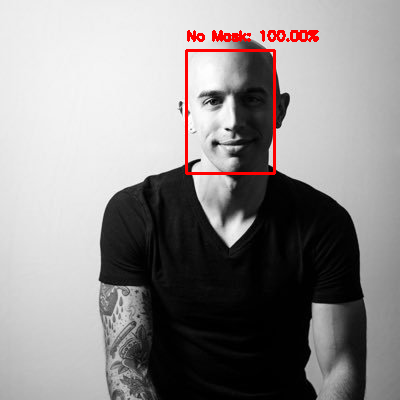

In [87]:
#loop over the detections
from google.colab.patches import cv2_imshow

for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]
    
    
    if confidence>0.5:
        #we need the X,Y coordinates
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY)=box.astype('int')
        
        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
        
        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=image[startY:endY, startX:endX]
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face,(224,224))
        face=img_to_array(face)
        face=preprocess_input(face)
        face=np.expand_dims(face,axis=0)
        
        (mask,withoutMask)=model.predict(face)[0]
        
        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)
        
        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)
        
        #display the label and bounding boxes
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        
        
        
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()